In [1]:
import PyQt6.QtCore
import os
os.environ["QT_API"] = "pyqt5"


# Use qt backend for matplotlab to use interactive mne plots
%matplotlib qt

In [2]:
import mne 
import analysis.processing
import matplotlib.pyplot as plt
import pandas as pd
import csv 

mne.set_log_level(verbose='WARNING', return_old_level=False, add_frames=None)

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200 # 200 

/Users/erangad/Documents/Research/oddball-task/src/analysis/processing.py:49: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_filtered.set_montage(montage)


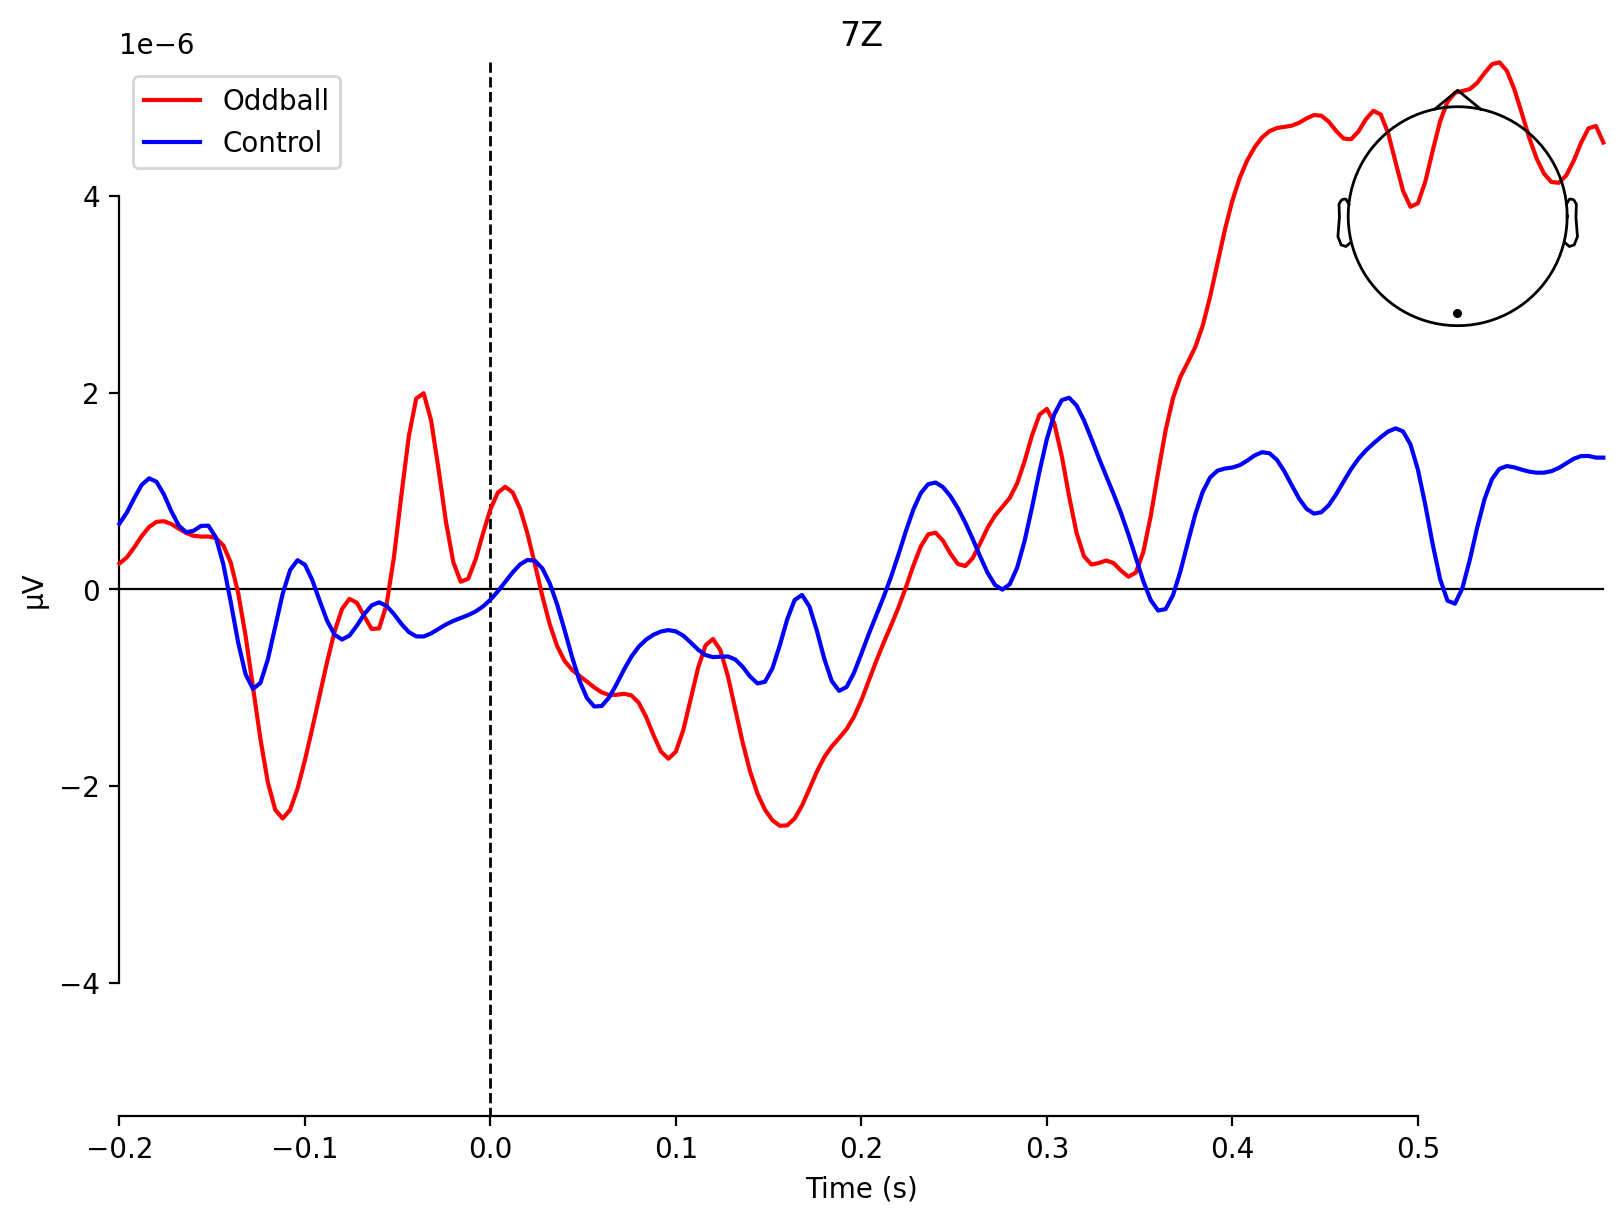

In [3]:
participant_id = 161

# loading data
raw = analysis.processing.loadData(participant_id)

# preprocessig 
raw = analysis.processing.preprocessing(raw) 

#generate epochs
epochs_1, event_dict = analysis.processing.eventEpochdata(raw)


oddball = epochs_1["visual/image_display/onset/stimulus/non_freq"].average()
control = epochs_1["visual/image_display/onset/stimulus/freq"].average()

#PZ ~ 7Z

evokeds = dict(Oddball=oddball, Control=control)
fig  =  mne.viz.plot_compare_evokeds(evokeds, picks=['7Z'], styles = {"Oddball": {"color" :'red'}, "Control":{"color": 'blue'}})

In [3]:
# read group evokeds

oddball_list = []
control_list = []

for pnum in (1, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 151, 161, 171, 181,191):
    raw = analysis.processing.loadData(pnum)

    # preprocessig 
    raw = analysis.processing.preprocessing(raw)
    epochs, event_dict = analysis.processing.eventEpochdata(raw)


    oddball = epochs["visual/image_display/onset/stimulus/non_freq"].average()
    control = epochs["visual/image_display/onset/stimulus/freq"].average()
    oddball_list.append(oddball)
    control_list.append(control)



title= "ERP"
roi =['7Z']

evokeds = dict(
    oddball=  oddball_list,
    control= control_list,
)

Non inverted Y axis

c:\Users\erang\Desktop\Oddball\src\analysis\processing.py:170: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(evokeds, picks= roi, ci = ci ,


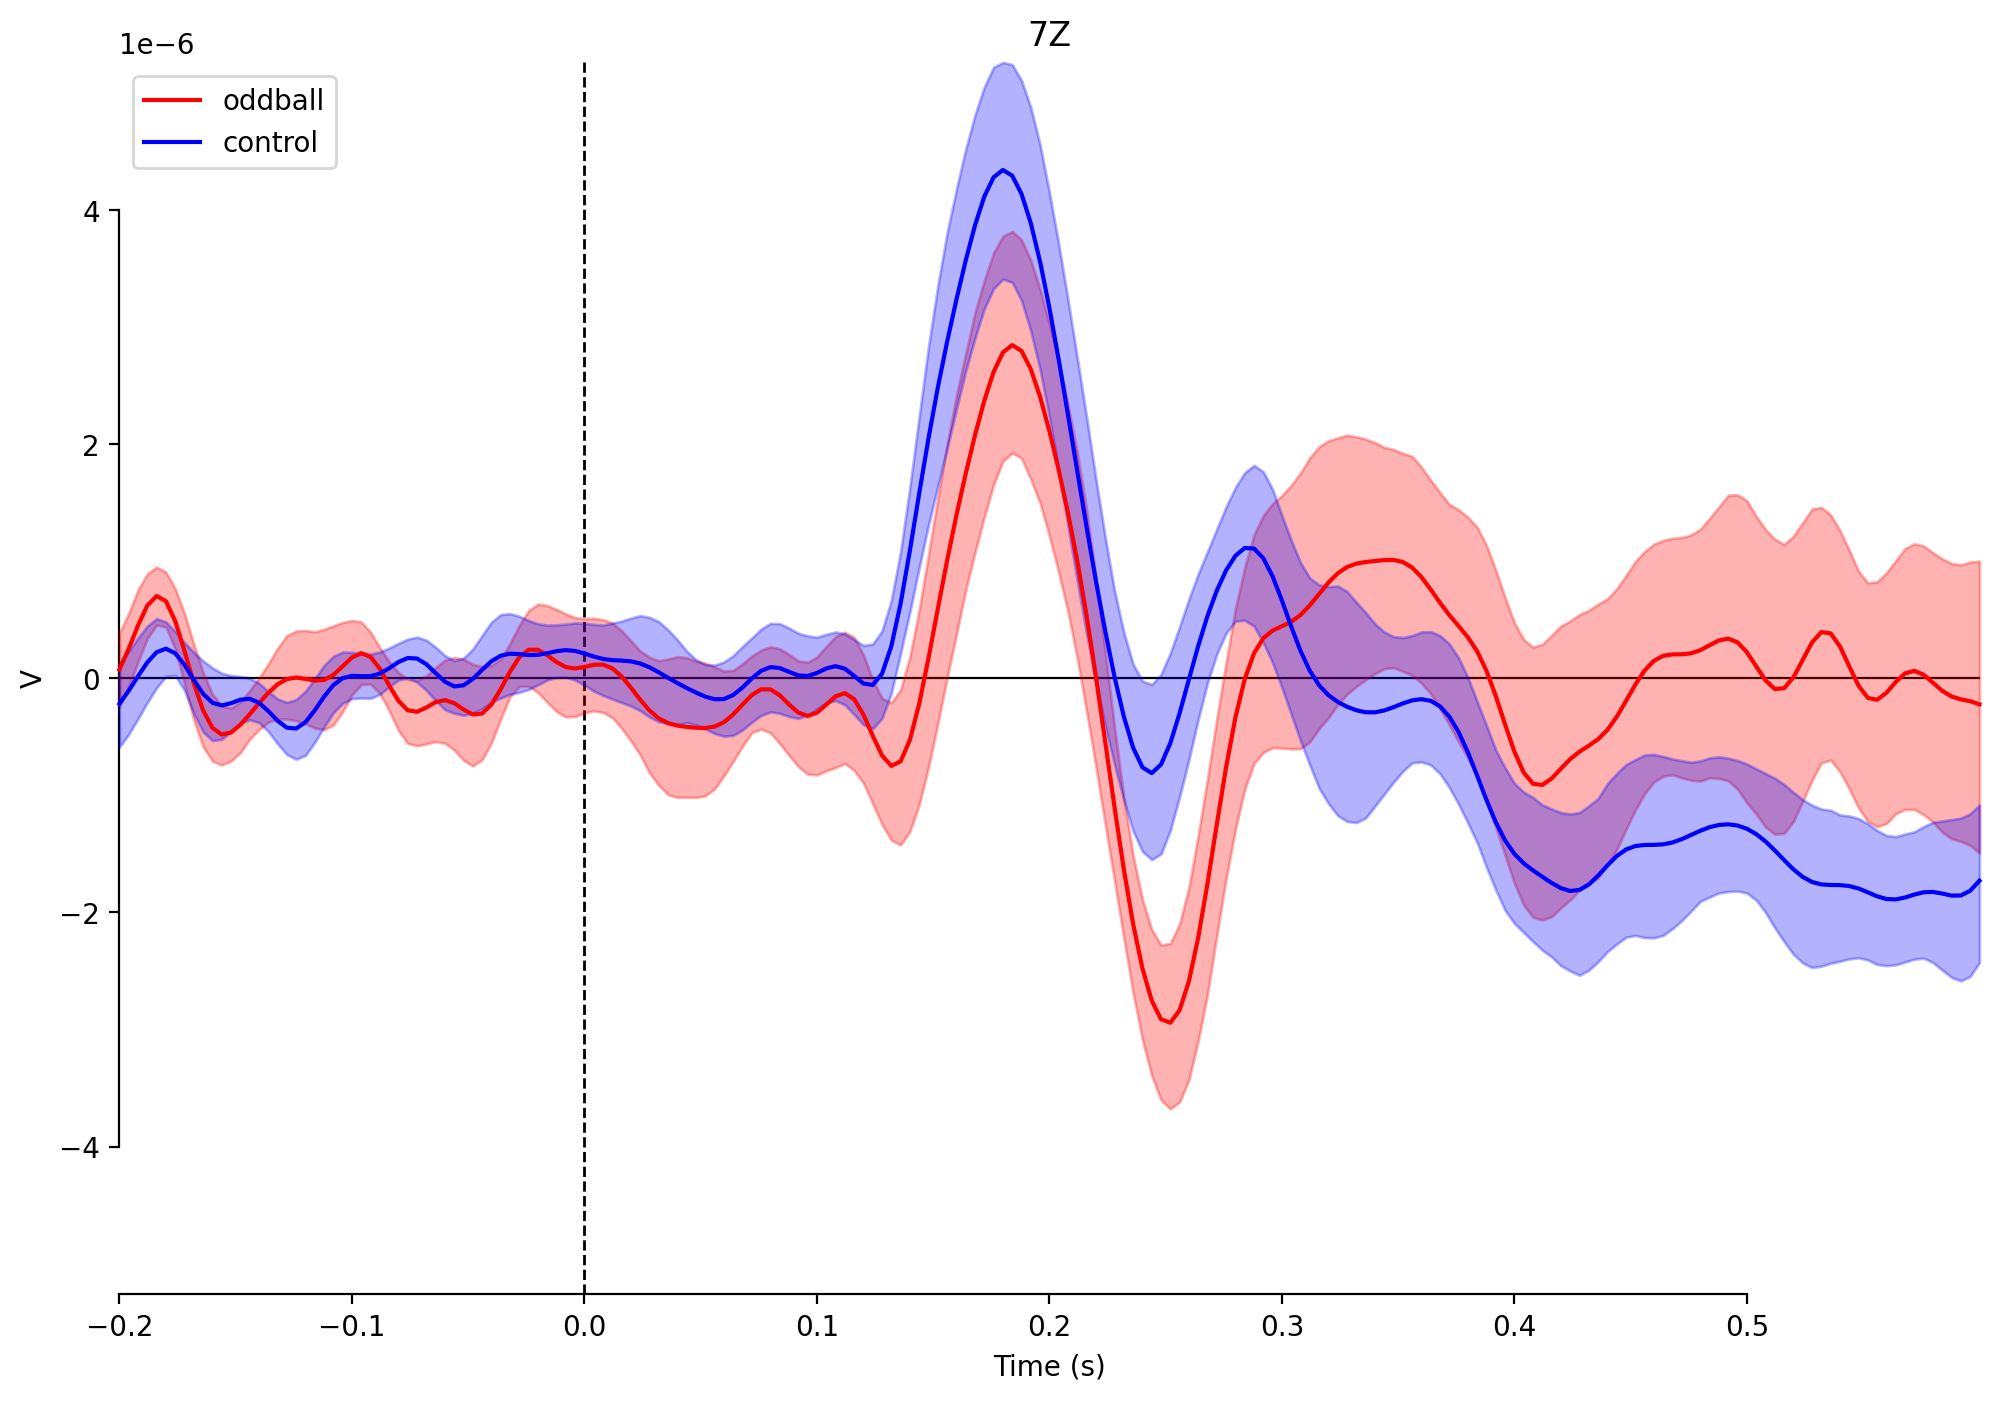

In [4]:
#plot evokeds at 0.9 CI
analysis.processing.getERP(evokeds, roi = roi, ci = 0.9, invert = False)


c:\Users\erang\Desktop\Oddball\src\analysis\processing.py:170: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(evokeds, picks= roi, ci = ci ,


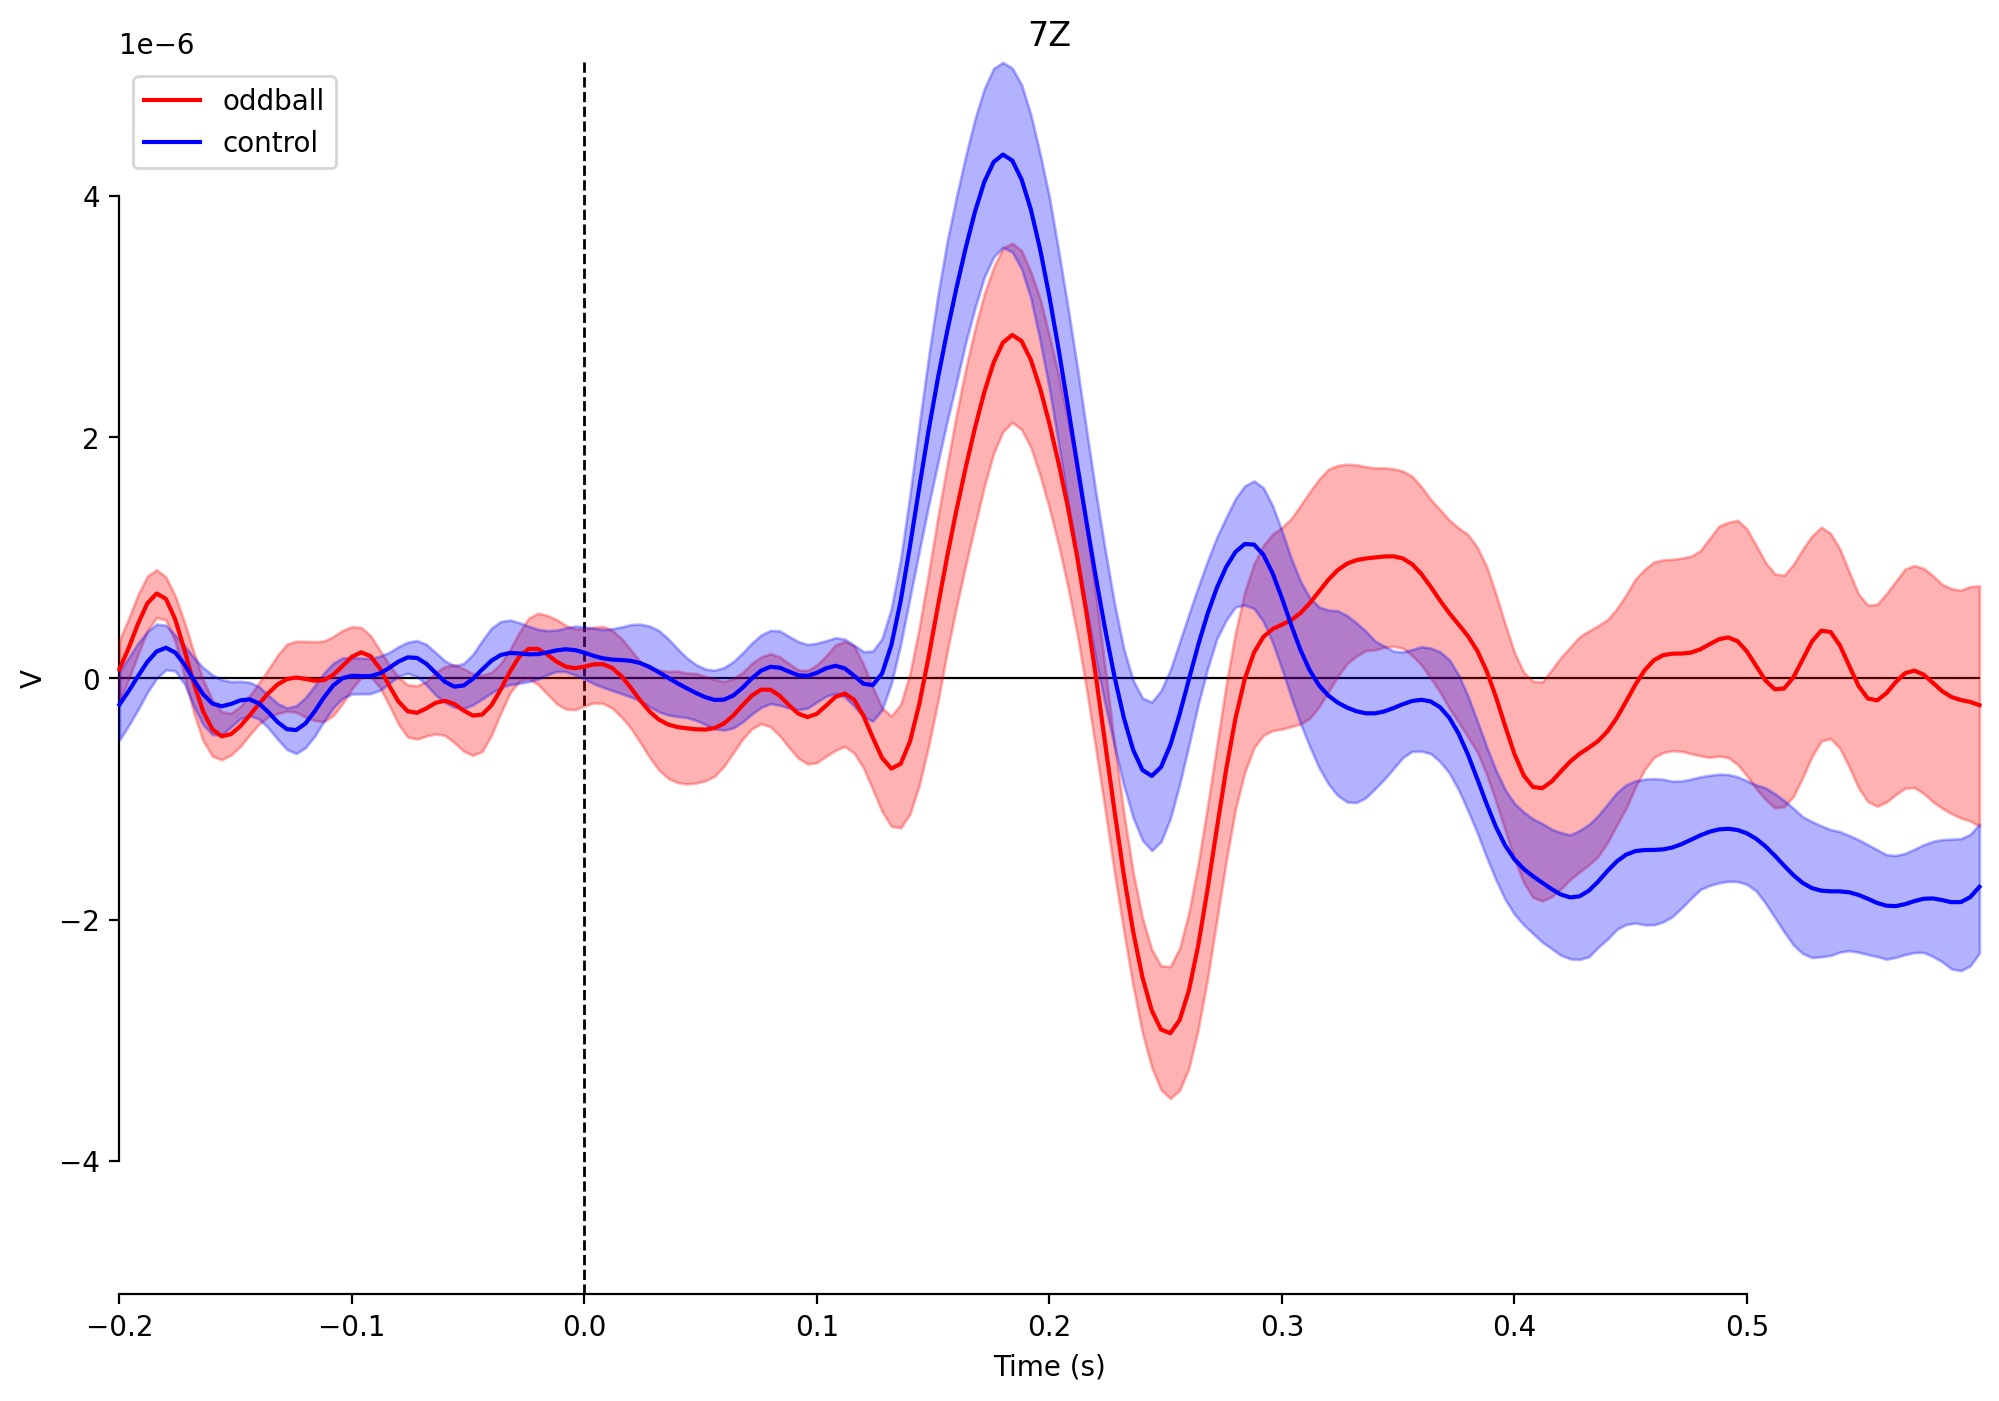

In [5]:
#plot evokeds at 0.8 CI
analysis.processing.getERP(evokeds, roi = roi, ci = 0.8, invert = False)

Inverted

c:\Users\erang\Desktop\Oddball\src\analysis\processing.py:170: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(evokeds, picks= roi, ci = ci ,


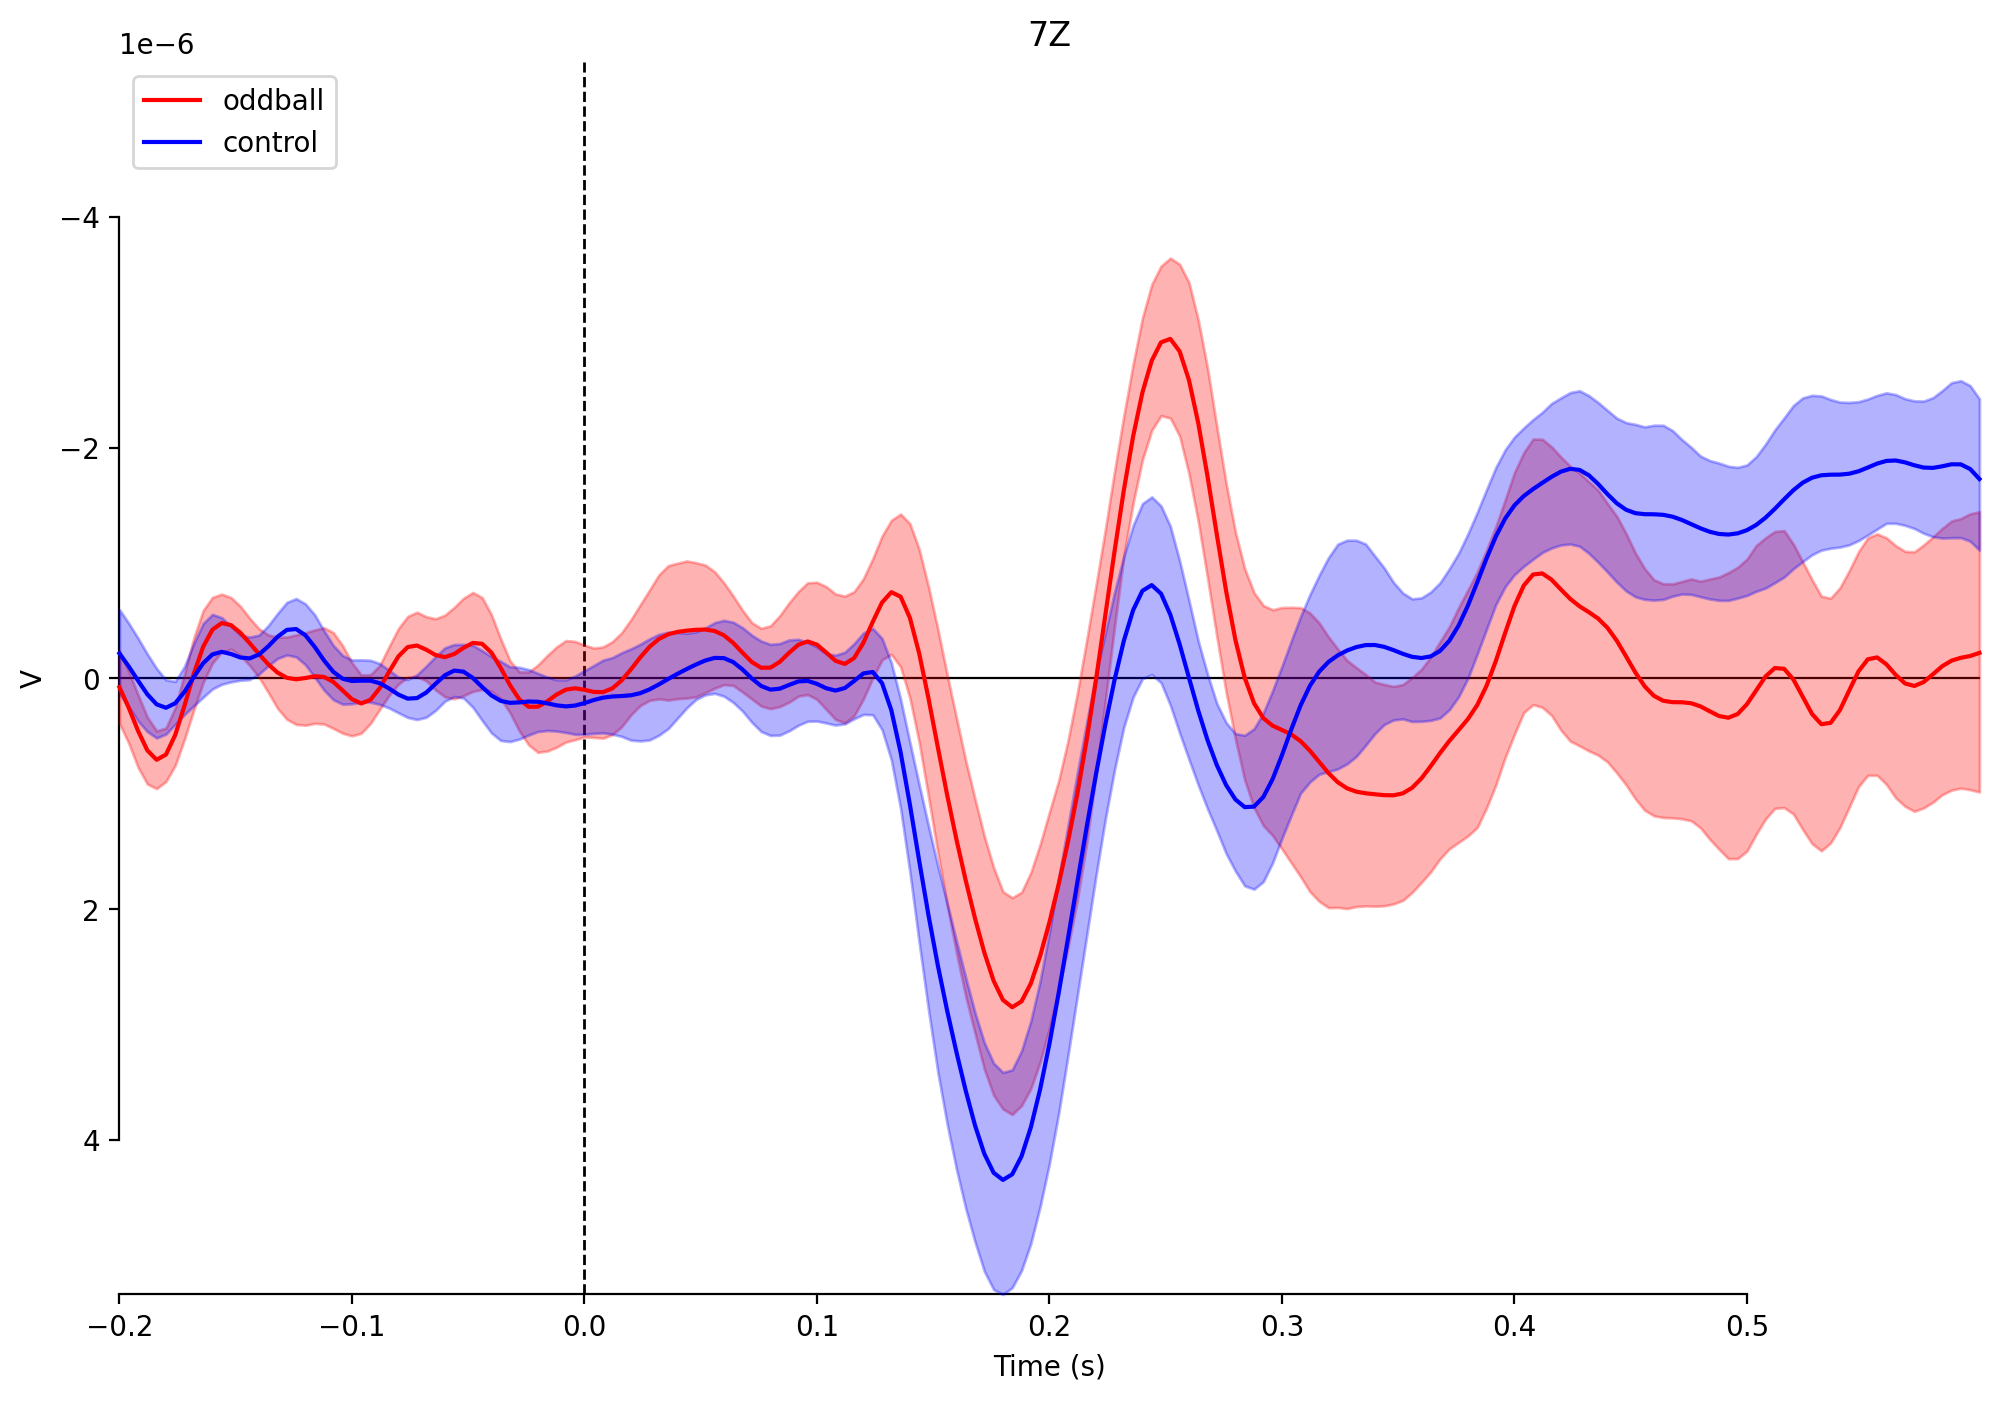

In [6]:
#plot evokeds at 0.9 CI
analysis.processing.getERP(evokeds, roi = roi, ci = 0.9, invert = True)

c:\Users\erang\Desktop\Oddball\src\analysis\processing.py:170: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(evokeds, picks= roi, ci = ci ,


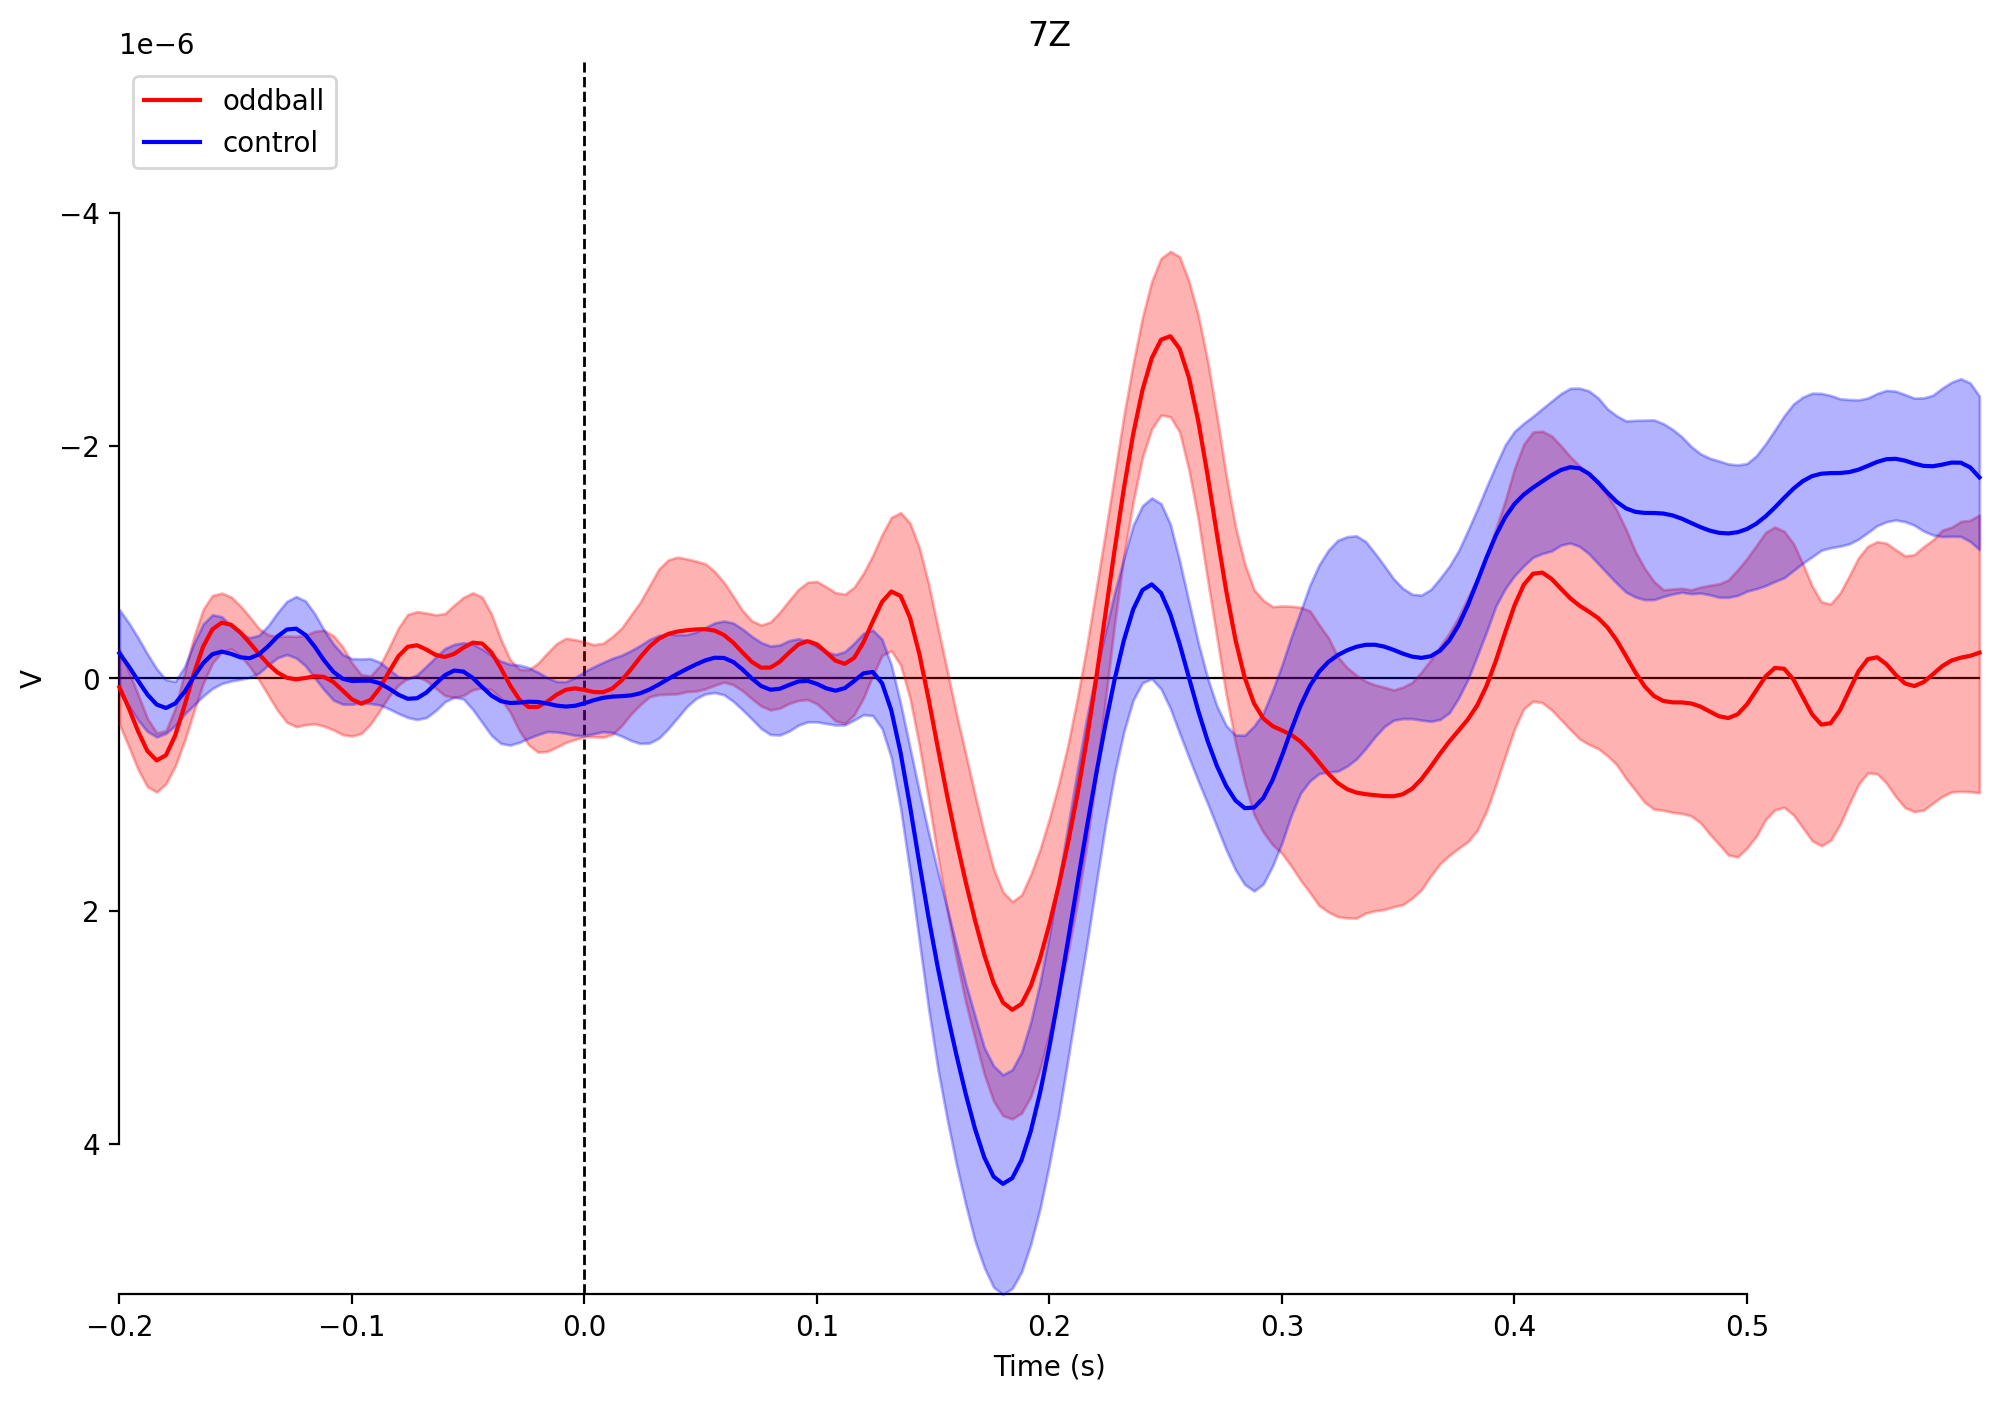

In [7]:
#plot evokeds at 0.8 CI
analysis.processing.getERP(evokeds, roi = roi, ci = 0.9, invert = True)

In [8]:
diff_waves = []
for i in range(len(oddball_list)):
    diff_waves.append(mne.combine_evoked([oddball_list[i], control_list[i]], weights=[-1, 1]))

C:\Users\erang\AppData\Local\Temp\ipykernel_17496\1335212416.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds({contrast:diff_waves},


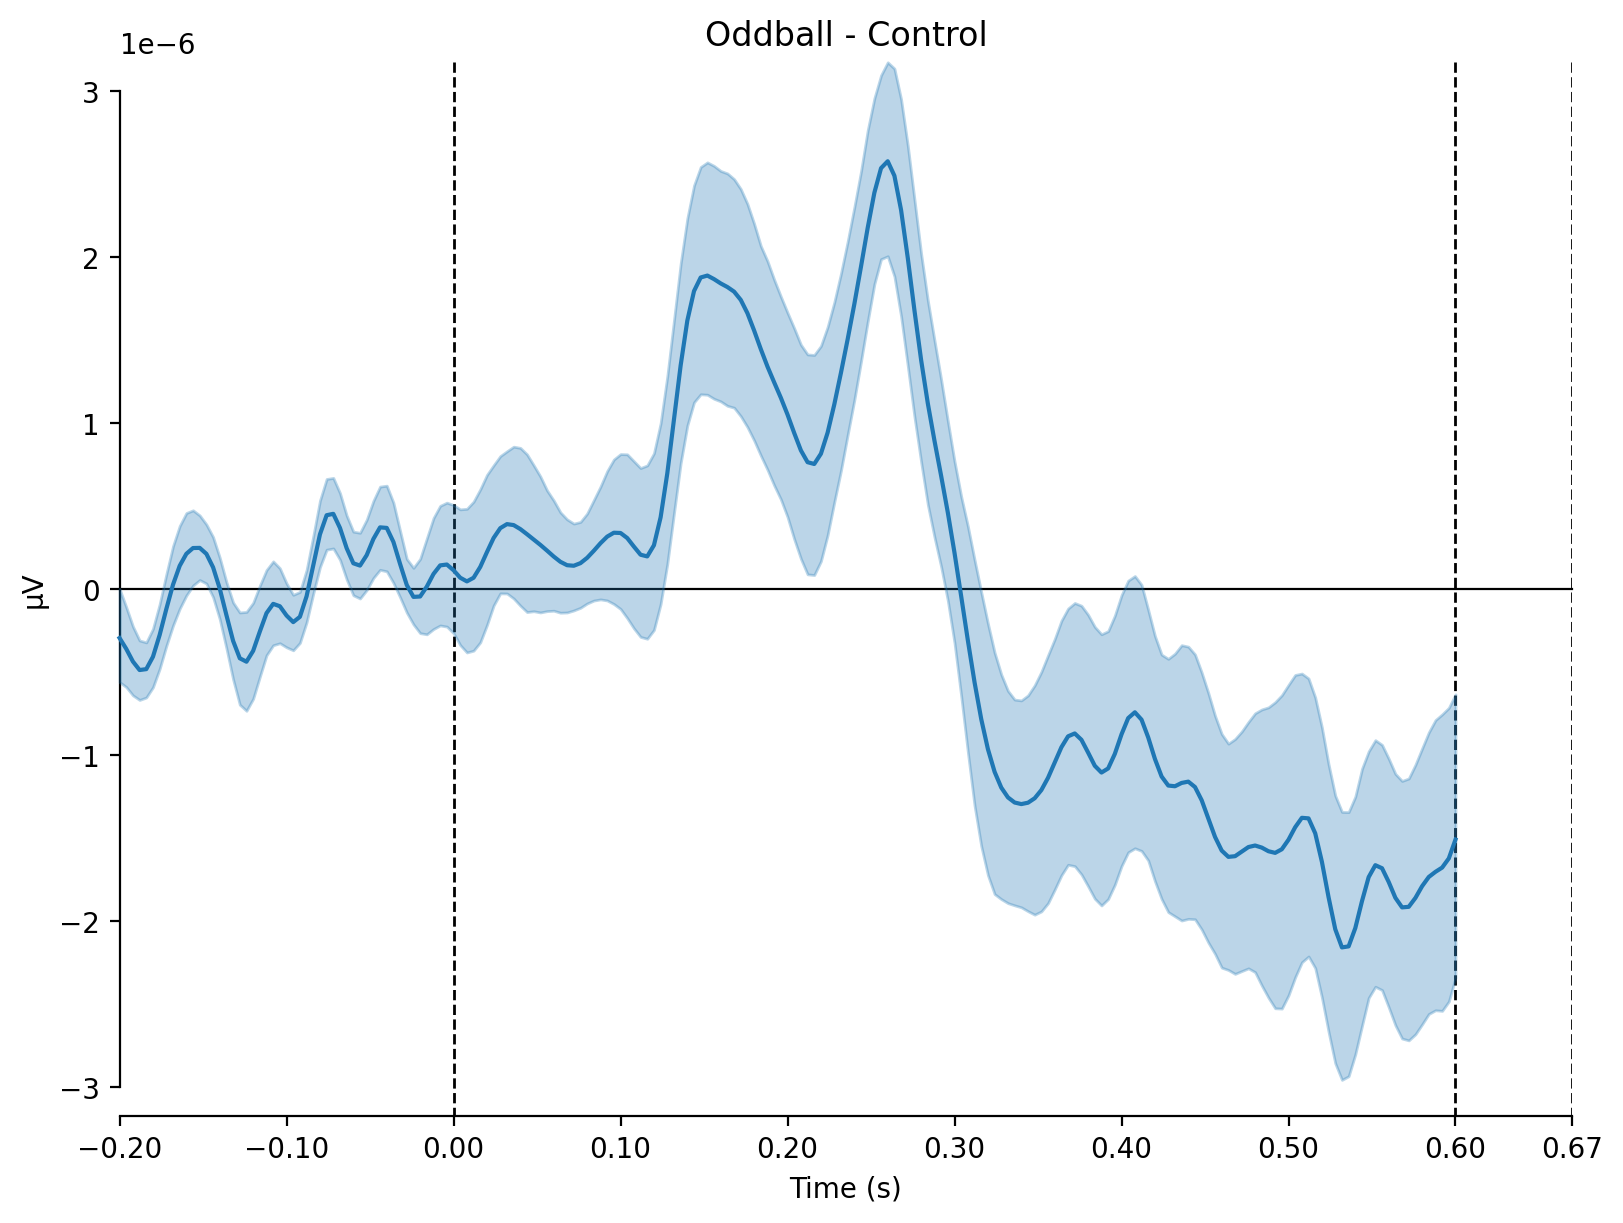

In [9]:
import matplotlib.pyplot as plt
contrast = 'Oddball - Control'
mne.viz.plot_compare_evokeds({contrast:diff_waves},
                            legend=None, title=contrast,
                             picks=roi, ci =0.8, vlines = [0.0, 0.6, 0.67]
                            )
plt.show()

In [3]:
# read group evokeds

oddball_list = []
control_list = []

for pnum in (151, 152, 153, 161, 162, 163, 171, 172, 173, 181,\
                182, 183, 191, 192, 193, 201, 202, 203, 211, 212, 213,\
                    221, 222, 223, 231, 232, 233, ):
    raw = analysis.processing.loadData(pnum)

    # preprocessig 
    raw = analysis.processing.preprocessing(raw)
    epochs, event_dict = analysis.processing.eventEpocshByBlocks(raw)

    for bnum in (0, 1, 2):
        block = "b" + str(bnum)

        oddball = epochs[f"oddball & block == '{block}'"].average()
        control = epochs[f"control & block == '{block}'"].average()
        oddball_list.append(oddball)
        control_list.append(control)



title= "ERP"
roi =['7Z']

evokeds = dict(
    oddball=  oddball_list,
    control= control_list,
)

/Users/erangad/Documents/Research/oddball-task/src/analysis/processing.py:49: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_filtered.set_montage(montage)
/Users/erangad/Documents/Research/oddball-task/src/analysis/processing.py:49: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_filtered.set_montage(montage)
/Users/erangad/Documents/Research/oddball-task/src/analysis/processing.py:49: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_filtered.set_montage(montage)
/Users/erangad/Documents/Research/oddball-task/src/analysis/processing.py:49: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_filtered.set_montage(montage)
/Users/erangad/Documents/Research/oddball-task/src/analysis/processing.py:49: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown

In [4]:
analysis.processing.getERPMontage(evokeds)

In [82]:
mne.viz.plot_compare_evokeds(
    evokeds,
    picks="eeg",
    ci = 0.95,
    styles = {"oddball": {"color" :'red'}, 
                                        "control":{"color": 'blue'}}, 
    axes="topo",
    sphere='auto',
    ylim = dict(eeg=[-10e-6, 10e-6]) )

[<Figure size 3024x1588 with 63 Axes>]

In [8]:
#front

roi = ['1L', '1R','1Z','1LC', '1LB', '2L', '2R', '1RB', '1RC']
ci = 0.95
invert = False

fig, ax = plt.subplots()
mne.viz.plot_compare_evokeds(evokeds, picks= roi, ci = ci , 
                                styles = {"oddball": {"color" :'red'}, 
                                        "control":{"color": 'blue'}}, 
                                    show =False, axes = ax, combine ='mean' )
if(invert): 
    ax.invert_yaxis()
    
ax.set_ylabel("V")

plt.show()


In [7]:
#Occipital

roi = ['10L', '9Z','10R', '9L', '8Z', '9R']
ci = 0.95
invert = False

fig, ax = plt.subplots()
mne.viz.plot_compare_evokeds(evokeds, picks= roi, ci = ci , 
                                styles = {"oddball": {"color" :'red'}, 
                                        "control":{"color": 'blue'}}, 
                                    show =False, axes = ax, combine ='mean' )
if(invert): 
    ax.invert_yaxis()
    
ax.set_ylabel("V")

plt.show()


In [8]:
#Left

roi = ['3LB', '3LC','2LB', '1LA', '2LA', '2LC']
ci = 0.95
invert = False

fig, ax = plt.subplots()
mne.viz.plot_compare_evokeds(evokeds, picks= roi, ci = ci , 
                                styles = {"oddball": {"color" :'red'}, 
                                        "control":{"color": 'blue'}}, 
                                    show =False, axes = ax, combine ='mean' )
if(invert): 
    ax.invert_yaxis()
    
ax.set_ylabel("V")

plt.show()

In [9]:
#Right

roi = ['3RB', '3RC','2RB', '1RA', '2RA', '2RC']
ci = 0.95
invert = False

fig, ax = plt.subplots()
mne.viz.plot_compare_evokeds(evokeds, picks= roi, ci = ci , 
                                styles = {"oddball": {"color" :'red'}, 
                                        "control":{"color": 'blue'}}, 
                                    show =False, axes = ax, combine ='mean' )
if(invert): 
    ax.invert_yaxis()
    
ax.set_ylabel("V")

plt.show()

In [9]:
roi =['7Z']

In [10]:
#plot evokeds at 0.9 CI
analysis.processing.getERP(evokeds, roi = roi, ci = 0.95, invert = True)

In [52]:
#plot evokeds at 0.95 CI
analysis.processing.getERP(evokeds, roi = roi, ci = 0.95, invert = True, vlines = [0.0, 0.2586,0.3285])

TypeError: getERP() got an unexpected keyword argument 'vlines'

In [56]:
diff_waves = []
for i in range(len(oddball_list)):
    diff_waves.append(mne.combine_evoked([oddball_list[i], control_list[i]], weights=[-1, 1]))

In [61]:
import numpy as np
evoked_data = np.array([ [np.mean(np.mean(e.get_data(picks=roi, tmin=.308, tmax=.373), axis=1), axis=0)] for e in diff_waves])
from scipy import stats 

result = stats.ttest_1samp(evoked_data, 0)
t =  result.statistic
print(result)
pval = result.pvalue
# df = result.df
# print('t( df = ', str(round(df[0], 2)) ,')= ', str(round(t[0], 2)), 'p = ', str(round(pval[0], 4)))
print('P300 t( df = 81)= ', str(round(t[0], 2)), 'p = ', str(round(pval[0], 4)))

Ttest_1sampResult(statistic=array([-2.05895022]), pvalue=array([0.0427529]))
t( df = 81)=  -2.06 p =  0.0428


In [63]:
import numpy as np
evoked_data = np.array([ [np.mean(np.mean(e.get_data(picks=roi, tmin=.221, tmax=.297), axis=1), axis=0)] for e in diff_waves])
from scipy import stats 

result = stats.ttest_1samp(evoked_data, 0)
t =  result.statistic
print(result)
pval = result.pvalue
# df = result.df
# print('t( df = ', str(round(df[0], 2)) ,')= ', str(round(t[0], 2)), 'p = ', str(round(pval[0], 4)))
print(' N200 t( df = 81)= ', str(round(t[0], 2)), 'p = ', str(round(pval[0], 4)))

Ttest_1sampResult(statistic=array([3.45036624]), pvalue=array([0.0008965]))
 N200 t( df = 81)=  3.45 p =  0.0009


In [7]:
#plot evokeds at 0.9 CI
analysis.processing.getERP(evokeds, roi = ['1Z'], ci = 0.95, invert = True)

In [62]:
import matplotlib.pyplot as plt
roi = ['7Z']
invert = True

contrast = 'Oddball - Control'
fig, ax = plt.subplots()
mne.viz.plot_compare_evokeds({contrast:diff_waves},
                            legend=None, title=contrast,
                             picks=roi, ci =0.8, axes= ax ,vlines = [0.0, 0.2586,0.3285 ]
                            )
if(invert): 
    ax.invert_yaxis()
    
ax.set_ylabel("V")
plt.show()

In [76]:
import matplotlib.pyplot as plt
roi = ['1Z']
invert = True

contrast = 'Oddball - Control'
fig, ax = plt.subplots()
mne.viz.plot_compare_evokeds({contrast:diff_waves},
                            legend=None, title=contrast,
                             picks=roi, ci =0.8, axes= ax ,vlines = [0.0, 0.268]
                            )
if(invert): 
    ax.invert_yaxis()
    
ax.set_ylabel("V")
plt.show()

In [74]:
import numpy as np
evoked_data = np.array([ [np.mean(np.mean(e.get_data(picks=['1Z'], tmin=.205, tmax=.316), axis=1), axis=0)] for e in diff_waves])
from scipy import stats 

result = stats.ttest_1samp(evoked_data, 0)
t =  result.statistic
print(result)
pval = result.pvalue
# df = result.df
# print('t( df = ', str(round(df[0], 2)) ,')= ', str(round(t[0], 2)), 'p = ', str(round(pval[0], 4)))
print(' N200 t( df = 81)= ', str(round(t[0], 2)), 'p = ', str(round(pval[0], 4)))

Ttest_1sampResult(statistic=array([-3.41914214]), pvalue=array([0.00099106]))
 N200 t( df = 81)=  -3.42 p =  0.001


In [13]:
analysis.processing.getERP(evokeds, roi = ['2Z'], ci = 0.99, invert = True)

In [14]:
analysis.processing.getERP(evokeds, roi = ['9Z'], ci = 0.9, invert = True)

In [15]:
analysis.processing.getERP(evokeds, roi = ['3RB'], ci = 0.99, invert = True)

In [16]:
analysis.processing.getERP(evokeds, roi = ['3LB'], ci = 0.99, invert = True)

In [17]:
analysis.processing.getERP(evokeds, roi = ['1Z'], ci = 0.99, invert = True)

In [18]:
analysis.processing.getERP(evokeds, roi = ['1L'], ci = 0.99, invert = True)

In [19]:
analysis.processing.getERP(evokeds, roi = ['1R'], ci = 0.99, invert = True)

In [47]:
import numpy as np
evooddballs =evokeds['oddball']
evoodcontrol =evokeds['control']
info = evooddballs[0].info

evo_oddball_data_list_array = np.array([ ob.get_data() for ob in evooddballs])
evo_control_data_list_array = np.array([ ob.get_data() for ob in evoodcontrol])

ob_evoked_array = mne.EvokedArray(
    np.mean(evo_oddball_data_list_array * 1000000, 0), info, tmin=-0.2, nave=evo_oddball_data_list_array.shape[0], comment="odd balls"
)

control_evoked_array = mne.EvokedArray(
    np.mean(evo_control_data_list_array * 1000000, 0), info, tmin=-0.2, nave=evo_control_data_list_array.shape[0], comment="odd balls"
)
times = np.arange(-0.05, 0.6, 0.05)


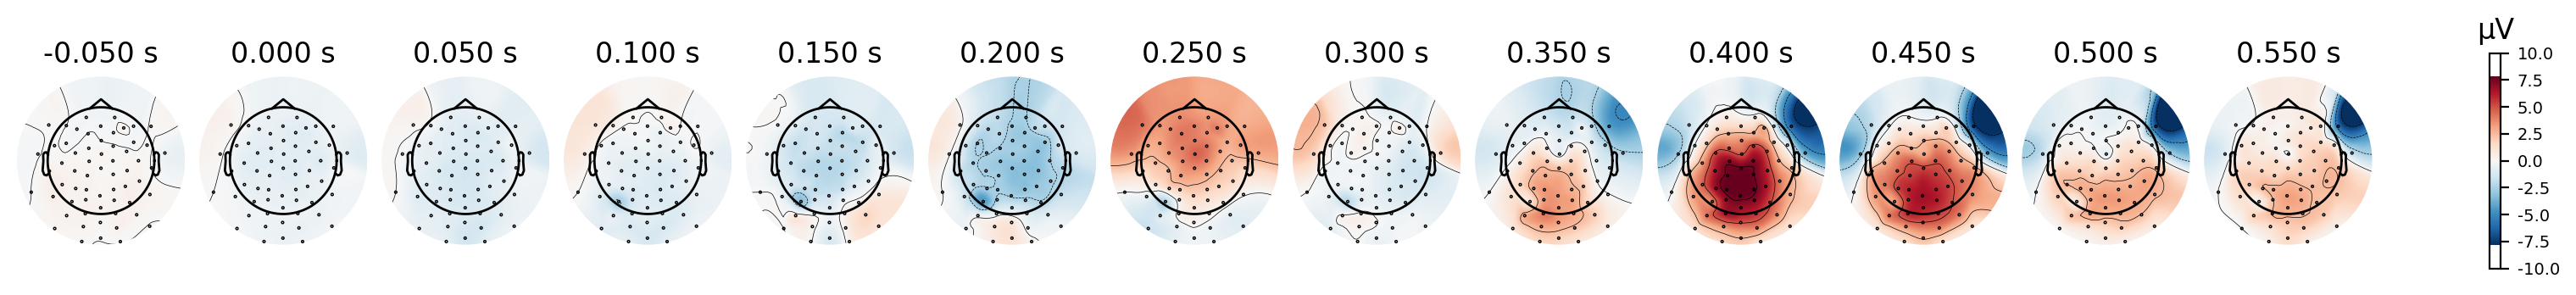

In [48]:
ob_evoked_array.plot_topomap(times, ch_type="eeg")

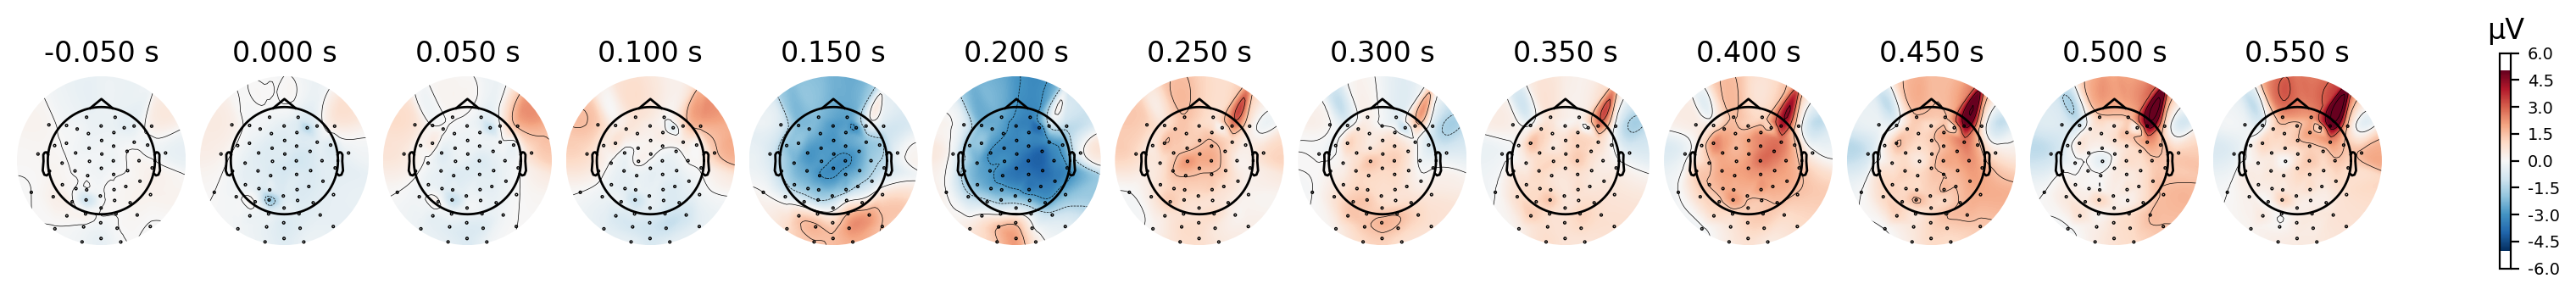

In [49]:
control_evoked_array.plot_topomap(times, ch_type="eeg")